In [ ]:
!apt install fonts-nanum fonts-nanum-extra
!ls /usr/share/fonts/truetype/nanum

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-extra
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 31.4 MB of archives.
After this operation, 120 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0 MB]
Fetched 31.4 MB in 3s (11.8 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126109 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (202

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.font_manager.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
mpl.rc('font', family='NanumGothic')
plt.rc("axes", unicode_minus=False)

In [ ]:
! pip install finnhub-python pandas nltk


In [ ]:
import transformers
print(transformers.__version__)

4.52.2


In [ ]:
import finnhub, pandas as pd, datetime as dt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


API_KEY = "d0hfc0hr01qv1u375an0d0hfc0hr01qv1u375ang"
client = finnhub.Client(api_key=API_KEY)

to_     = dt.date.today()
frm     = to_ - dt.timedelta(days=7)
aapl_news = client.company_news('AAPL', _from=frm.isoformat(), to=to_.isoformat())

titles = [n['headline'] for n in aapl_news]
df = pd.DataFrame({'headline': titles})

tok = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
labels = ["neg", "neu", "pos"]

def classify(text):
    with torch.no_grad():
        inputs = tok(text, return_tensors="pt", truncation=True)
        scores = model(**inputs).logits.softmax(dim=1)[0]
        return labels[scores.argmax()]

df['label'] = df['headline'].apply(classify)

# 3) 퍼센티지 출력
tot = len(df)
pos = (df.label == 'pos').sum() / tot * 100
neg = (df.label == 'neg').sum() / tot * 100
neu = 100 - pos - neg
print(f"최근 7일 AAPL 뉴스 ▶ 긍정 {pos:5.1f}% | 부정 {neg:5.1f}% | 중립 {neu:5.1f}%")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

최근 7일 AAPL 뉴스 ▶ 긍정  55.2% | 부정  26.2% | 중립  18.6%


In [ ]:
import finnhub, pandas as pd, datetime as dt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt

# 모델 로딩 (최초 1회만)
tok = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
labels = ["neg", "neu", "pos"]

# 감성 분석 함수
def classify(text):
    with torch.no_grad():
        inputs = tok(text, return_tensors="pt", truncation=True)
        scores = model(**inputs).logits.softmax(dim=1)[0]
        return labels[scores.argmax()]

# 종목별 감성 분석 및 시각화
def analyze_stock_sentiment(ticker, api_key="YOUR_API_KEY_HERE", days=7):
    client = finnhub.Client(api_key=api_key)

    to_ = dt.date.today()
    frm = to_ - dt.timedelta(days=days)

    news = client.company_news(ticker, _from=frm.isoformat(), to=to_.isoformat())
    if not news:
        print(f"{ticker}: 최근 {days}일간 뉴스가 없습니다.")
        return

    # 뉴스 텍스트 결합
    data = []
    for n in news:
        headline = n.get("headline", "")
        summary = n.get("summary", "")
        full_text = f"{headline}. {summary}".strip()
        data.append((headline, full_text, pd.to_datetime(n["datetime"], unit='s').date()))

    df = pd.DataFrame(data, columns=["headline", "full_text", "date"])

    df["label"] = df["full_text"].apply(classify)

    # 퍼센티지 계산
    tot = len(df)
    pos = (df.label == 'pos').sum() / tot * 100
    neg = (df.label == 'neg').sum() / tot * 100
    neu = 100 - pos - neg
    print(f"\n📰 {ticker} 뉴스 감성 요약 (최근 {days}일)")
    print(f"긍정 {pos:5.1f}% | 부정 {neg:5.1f}% | 중립 {neu:5.1f}%")

    # 일자별 감성 분포
    daily_counts = df.groupby(['date', 'label']).size().unstack(fill_value=0)
    daily_percent = daily_counts.div(daily_counts.sum(axis=1), axis=0) * 100

    # 시각화
    daily_percent.plot(kind='line', marker='o', figsize=(12, 6))
    plt.title(f"{ticker} 뉴스 감성 추이 (최근 {days}일)")
    plt.ylabel("비율 (%)")
    plt.xlabel("날짜")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend(title='감성')
    plt.tight_layout()
    plt.show()



📰 AAPL 뉴스 감성 요약 (최근 2일)
긍정  44.4% | 부정  26.7% | 중립  28.9%


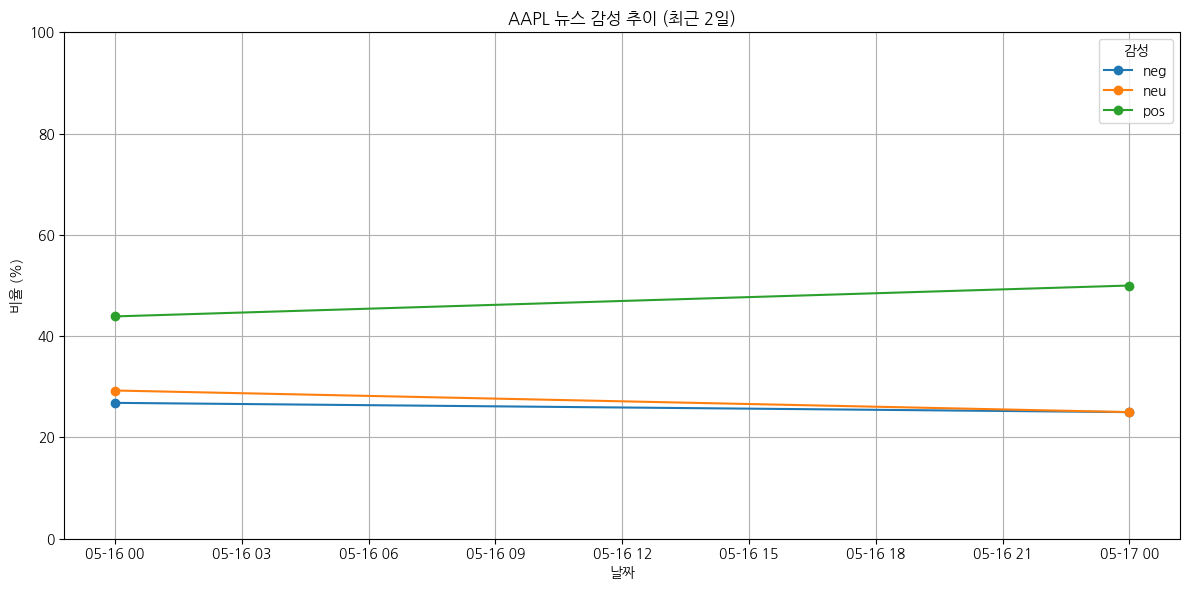

In [ ]:
analyze_stock_sentiment("AAPL", api_key="d0hfc0hr01qv1u375an0d0hfc0hr01qv1u375ang")



📰 TSLA 뉴스 감성 요약 (최근 7일)
긍정  40.9% | 부정  28.8% | 중립  30.2%


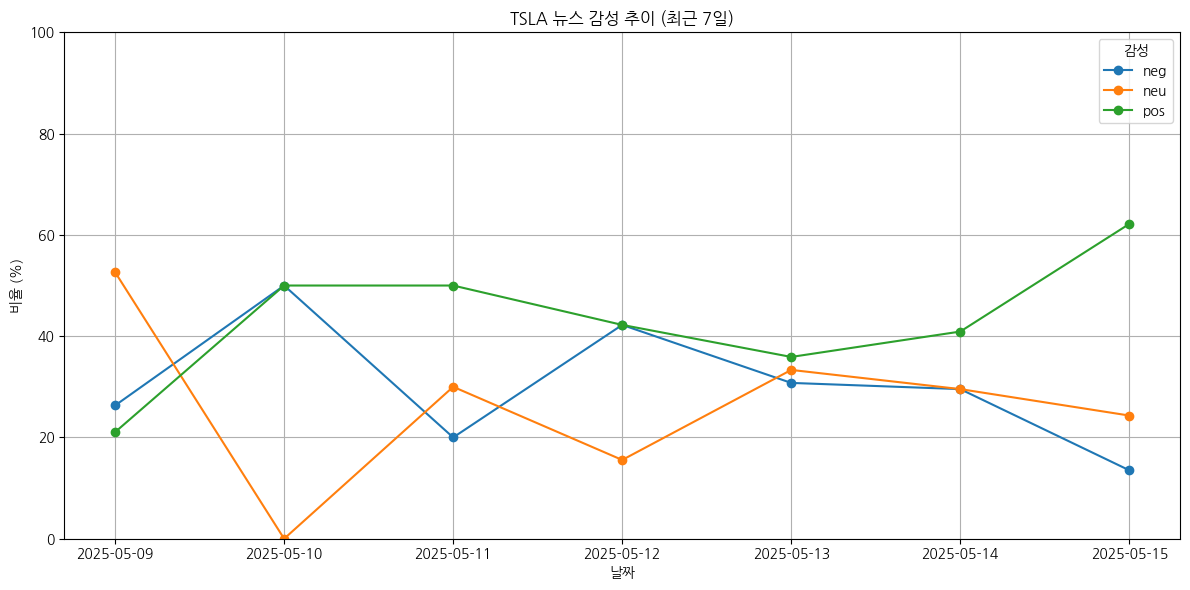

In [ ]:
analyze_stock_sentiment("TSLA", api_key="d0hfc0hr01qv1u375an0d0hfc0hr01qv1u375ang")


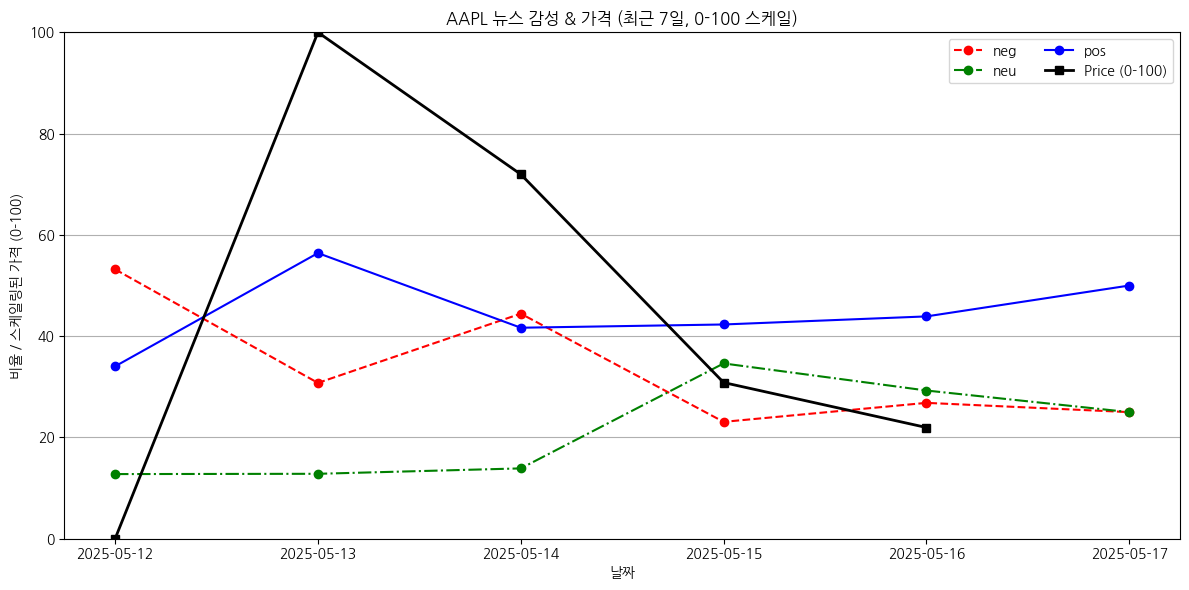

긍정 43.4%  |  부정 35.2%  |  중립 21.5%


In [ ]:
import finnhub, yfinance as yf, pandas as pd, datetime as dt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, matplotlib.pyplot as plt

tok   = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
labels = ["neg", "neu", "pos"]

def classify(text):
    with torch.no_grad():
        return labels[
            model(**tok(text, return_tensors="pt", truncation=True)
                 ).logits.softmax(1)[0].argmax()
        ]

def analyze_stock_sentiment(ticker, api_key, days=7, yf_interval="1d",
                             auto_adjust=False, scale_price=True):   # ★
    today, start = dt.date.today(), dt.date.today() - dt.timedelta(days=days)

    # 1) 뉴스
    fh = finnhub.Client(api_key=api_key)
    news = fh.company_news(ticker, _from=start.isoformat(), to=today.isoformat())
    if not news:
        print("뉴스 없음"); return

    df = pd.DataFrame(
        [(n["headline"],
          f'{n["headline"]}. {n["summary"]}'.strip(),
          pd.to_datetime(n["datetime"], unit="s").date())
         for n in news],
        columns=["headline", "full_text", "date"])
    df["label"] = df["full_text"].apply(classify)

    daily = (
        df.groupby(["date", "label"]).size().unstack(fill_value=0)
          .pipe(lambda x: x.div(x.sum(1), 0) * 100)
          .reindex(columns=labels, fill_value=0)
    )

    # 2) yfinance 가격
    close = (
        yf.download(ticker, start=str(start), end=str(today + dt.timedelta(1)),
                    interval=yf_interval, auto_adjust=auto_adjust,
                    progress=False)["Close"]
        .dropna()
    )
    close.index = close.index.date

    # ★ 3) 가격 스케일링
    if scale_price:
        price_line = (close - close.min()) / (close.max() - close.min()) * 100
        price_label = "Price (0-100)"
    else:
        price_line, price_label = close, "Close Price"

    # 4) 시각화 (같은 축)
    fig, ax = plt.subplots(figsize=(12, 6))
    styles = ["r--", "g-.", "b-"]
    for lab, sty in zip(labels, styles):
        ax.plot(daily.index, daily[lab], sty, marker="o", label=lab)

    # ★ 스케일링된 가격도 같은 y축 사용
    ax.plot(price_line.index, price_line.values, "k-", linewidth=2,
            marker="s", label=price_label)

    ax.set_ylim(0, 100); ax.set_ylabel("비율 / 스케일링된 가격 (0-100)")
    ax.set_xlabel("날짜"); ax.grid(True, axis="y")
    ax.set_title(f"{ticker} 뉴스 감성 & 가격 (최근 {days}일, 0-100 스케일)")
    ax.legend(ncol=2); plt.tight_layout(); plt.show()

    # 5) 텍스트 요약
    tot = len(df)
    pos = (df.label == "pos").sum() / tot * 100
    neg = (df.label == "neg").sum() / tot * 100
    neu = 100 - pos - neg
    print(f"긍정 {pos:4.1f}%  |  부정 {neg:4.1f}%  |  중립 {neu:4.1f}%")

# ─ 사용 예
analyze_stock_sentiment("AAPL", api_key="d0hfc0hr01qv1u375an0d0hfc0hr01qv1u375ang", days=7)


#Nvdia

In [ ]:
!pip install requests-cache


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 5.6 MB/s eta 0:00:00


In [ ]:
import finnhub
import pandas as pd
import datetime as dt
import time
import requests_cache
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ─── 1) 캐시 설정 및 초기화 ─────────────────────────────────────────────
requests_cache.install_cache('finnhub_cache', expire_after=86400)
requests_cache.clear()  # 이전에 잘못 캐시된 응답이 남아있다면 모두 삭제

# ─── 2) FinBERT 모델 로딩 (최초 1회) ────────────────────────────
tok   = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
labels = ["neg", "neu", "pos"]

def classify(text: str) -> str:
    """한 문장에 대해 FinBERT로 감성 분류"""
    with torch.no_grad():
        inputs = tok(text, return_tensors="pt", truncation=True)
        scores = model(**inputs).logits.softmax(dim=1)[0]
    return labels[int(scores.argmax())]

# ─── 3) 일별 감성 비율 계산 함수 ─────────────────────────────────
def fetch_daily_sentiment(
    ticker: str,
    start_date: str,   # "YYYY-MM-DD"
    end_date:   str,
    api_key:    str
) -> pd.DataFrame:
    client = finnhub.Client(api_key=api_key)

    # 캐시를 잠시 비활성화하고 실제 API 호출 (디버깅용)
    with requests_cache.disabled():
        news = client.company_news(
            ticker,
            _from=start_date,
            to=end_date
        )
    print(f"▶️ {ticker} {start_date}~{end_date} 뉴스 건수: {len(news)} 건")

    # 뉴스가 없으면 날짜 인덱스만 있는 0% DataFrame 리턴
    all_days = pd.date_range(start=start_date, end=end_date, freq="D").date
    if not news:
        return pd.DataFrame({
            "Date": all_days,
            "pos": 0.0,
            "neu": 0.0,
            "neg": 0.0
        })

    # 필요한 필드만 뽑아서 DataFrame 생성
    data = []
    for n in news:
        date = pd.to_datetime(n["datetime"], unit='s').date()
        text = (n.get("headline","") + ". " + n.get("summary","")).strip()
        data.append((date, text))
    df = pd.DataFrame(data, columns=["Date","Text"])

    # 감성 레이블 매핑
    df["Label"] = df["Text"].apply(classify)

    # 일별 Counts → 비율로 변환 (NaN 없이)
    daily_counts  = df.groupby(["Date","Label"]).size().unstack(fill_value=0)
    daily_percent = daily_counts.div(daily_counts.sum(axis=1), axis=0).fillna(0) * 100

    # 날짜 행이 빠진 날에도 0% 로 채워주기
    daily_percent = daily_percent.reindex(all_days, fill_value=0)

    # 컬럼 순서 & 날짜 리셋
    result = daily_percent.reset_index().rename(columns={
        "index": "Date",
        "neg":   "neg",
        "neu":   "neu",
        "pos":   "pos"
    })[["Date","pos","neu","neg"]]

    return result


API_KEY  = "d0hfc0hr01qv1u375an0d0hfc0hr01qv1u375ang"
TICKER   = "NVDA"
TRAIN    = fetch_daily_sentiment(TICKER, "2025-03-01", "2025-04-30", API_KEY)
TEST     = fetch_daily_sentiment(TICKER, "2025-05-01", "2025-05-14", API_KEY)

# CSV로 저장
TRAIN.to_csv("nvda_sentiment_train.csv", index=False)
TEST.to_csv("nvda_sentiment_test.csv",   index=False)

print("✅ 완료: nvda_sentiment_train.csv, nvda_sentiment_test.csv 생성됨")


▶️ AAPL 2025-03-01~2025-04-30 뉴스 건수: 222 건
▶️ AAPL 2025-05-01~2025-05-14 뉴스 건수: 223 건
✅ 완료: nvda_sentiment_train.csv, nvda_sentiment_test.csv 생성됨


In [ ]:
import finnhub
import pandas as pd
import datetime as dt
import time
import requests_cache
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ─── 1) 캐시 설정 및 초기화 ─────────────────────────────────────────────
requests_cache.install_cache('finnhub_cache', expire_after=86400)
requests_cache.clear()

# ─── 2) FinBERT 모델 로딩 ────────────────────────────────────────────────
tok   = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
labels = ["neg", "neu", "pos"]

def classify(text: str) -> str:
    with torch.no_grad():
        inputs = tok(text, return_tensors="pt", truncation=True)
        scores = model(**inputs).logits.softmax(dim=1)[0]
    return labels[int(scores.argmax())]

# ─── 3) 일별 감성 비율 계산 (단일 구간) ─────────────────────────────────
def fetch_daily_sentiment(
    ticker: str,
    start_date: str,
    end_date:   str,
    api_key:    str
) -> pd.DataFrame:
    client = finnhub.Client(api_key=api_key)
    with requests_cache.disabled():
        news = client.company_news(
            ticker,
            _from=start_date,
            to=end_date
        )
    print(f"▶️ {start_date}~{end_date} → {len(news)}건")

    all_days = pd.date_range(start=start_date, end=end_date, freq="D").date
    if not news:
        return pd.DataFrame({"Date": all_days, "pos":0.0, "neu":0.0, "neg":0.0})

    data = []
    for n in news:
        ts = n.get("datetime")
        if not isinstance(ts, (int, float)):
            continue  # 잘못된 timestamp 건너뛰기
        try:
            date = pd.to_datetime(ts, unit='s').date()
        except Exception:
            continue
        text = (n.get("headline", "") + ". " + n.get("summary", "")).strip()
        data.append((date, text))
    df = pd.DataFrame(data, columns=["Date","Text"])
    df["Label"] = df["Text"].apply(classify)

    daily_counts  = df.groupby(["Date","Label"]).size().unstack(fill_value=0)
    daily_percent = daily_counts.div(daily_counts.sum(axis=1), axis=0).fillna(0) * 100
    daily_percent = daily_percent.reindex(all_days, fill_value=0)

    result = daily_percent.reset_index().rename(columns={"index":"Date"})[["Date","pos","neu","neg"]]
    return result

# ─── 4) 구간을 7일씩 잘라서 호출하고 합치기 ───────────────────────────────
def fetch_in_chunks(
    ticker: str,
    overall_start: str,
    overall_end:   str,
    api_key:       str,
    chunk_days:    int = 7
) -> pd.DataFrame:
    start = dt.datetime.fromisoformat(overall_start).date()
    end   = dt.datetime.fromisoformat(overall_end).date()
    frames = []

    while start <= end:
        chunk_end = min(start + dt.timedelta(days=chunk_days-1), end)
        df_chunk  = fetch_daily_sentiment(
            ticker,
            start.isoformat(),
            chunk_end.isoformat(),
            api_key
        )
        frames.append(df_chunk)
        start = chunk_end + dt.timedelta(days=1)
        time.sleep(1)  # Optional: API 안정화를 위해

    # 중복 날짜 제거 후 정렬
    full = pd.concat(frames, ignore_index=True)
    full = full.drop_duplicates(subset="Date").sort_values("Date").reset_index(drop=True)
    return full

# ─── 5) 실행 예시 & CSV 저장 ─────────────────────────────────────────────
API_KEY = "d0hfc0hr01qv1u375an0d0hfc0hr01qv1u375ang"
TICKER  = "NVDA"

# 학습 기간 (2025-03-01 ~ 2025-04-30)
train_df = fetch_in_chunks(TICKER, "2025-01-01", "2025-05-31", API_KEY)

# 테스트 기간 (2025-05-01 ~ 2025-05-14)
#test_df  = fetch_in_chunks(TICKER, "2025-05-01", "2025-05-14", API_KEY)

# CSV로 저장
train_df.to_csv("nvda_sentiment_train.csv", index=False)
#test_df.to_csv("nvda_sentiment_test.csv",  index=False)

print("✅ 데이터 수집 및 CSV 저장 완료")


▶️ 2025-01-01~2025-01-07 → 230건
▶️ 2025-01-08~2025-01-14 → 216건
▶️ 2025-01-15~2025-01-21 → 88건
▶️ 2025-01-22~2025-01-28 → 158건
▶️ 2025-01-29~2025-02-04 → 169건
▶️ 2025-02-05~2025-02-11 → 137건
▶️ 2025-02-12~2025-02-18 → 137건
▶️ 2025-02-19~2025-02-25 → 127건
▶️ 2025-02-26~2025-03-04 → 237건
▶️ 2025-03-05~2025-03-11 → 158건
▶️ 2025-03-12~2025-03-18 → 246건
▶️ 2025-03-19~2025-03-25 → 239건
▶️ 2025-03-26~2025-04-01 → 234건
▶️ 2025-04-02~2025-04-08 → 241건
▶️ 2025-04-09~2025-04-15 → 235건
▶️ 2025-04-16~2025-04-22 → 238건
▶️ 2025-04-23~2025-04-29 → 235건
▶️ 2025-04-30~2025-05-06 → 230건
▶️ 2025-05-07~2025-05-13 → 236건
▶️ 2025-05-14~2025-05-20 → 217건
▶️ 2025-05-21~2025-05-27 → 234건
▶️ 2025-05-28~2025-05-31 → 224건
✅ 데이터 수집 및 CSV 저장 완료
